## 1. Data Splitting and Augmentation Strategy
The original dataset was first split into training, validation, and testing sets. Data augmentation and signal-level transformations were applied exclusively to the training portion to avoid any data leakage and to preserve the integrity of model evaluation.
- Original Dataset:
  - 20% test,
  - 20% validation,
  - 60% training -> Imbalance handling (expand align with max class)
- Augmented Dataset:
  - 100% training

## 2. Original Data Distribution Analysis
The original dataset comprised MRI images categorized into four classes based on the severity of Alzheimer's disease:
1. Non Demented
2. Very Mild Demented
3. Mild Demented
4. Moderate Demented

#### 2.1 Import Libraries

In [67]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.python.ops.stateful_random_ops import SEED_MAX

#### 2.2 Define Data Paths

In [68]:
DATASET_DIR = "../dataset/OriginalDataset"

#### 2.3 Analyze Data Distribution per Class

In [69]:
class_counts = []

for class_name in sorted(os.listdir(DATASET_DIR)):
    class_path = os.path.join(DATASET_DIR, class_name)

    if not os.path.isdir(class_path):
        continue

    image_files = [
        f for f in os.listdir(class_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    class_counts.append({
        "Class": class_name,
        "Image_Count": len(image_files)
    })

#### 2.4 Create DataFrame and Visualize Distribution

In [70]:
df_distribution = pd.DataFrame(class_counts)

# 计算总数
total_images = df_distribution["Image_Count"].sum()

# 计算比例（百分比）
df_distribution["Percentage"] = (
    df_distribution["Image_Count"] / total_images * 100
).round(2)

df_distribution

,Class,Image_Count,Percentage
0,MildDemented,896,14.0
1,ModerateDemented,64,1.0
2,NonDemented,3200,50.0
3,VeryMildDemented,2240,35.0


/tmp/ipykernel_198562/3520414954.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_distribution["Class"], rotation=45)


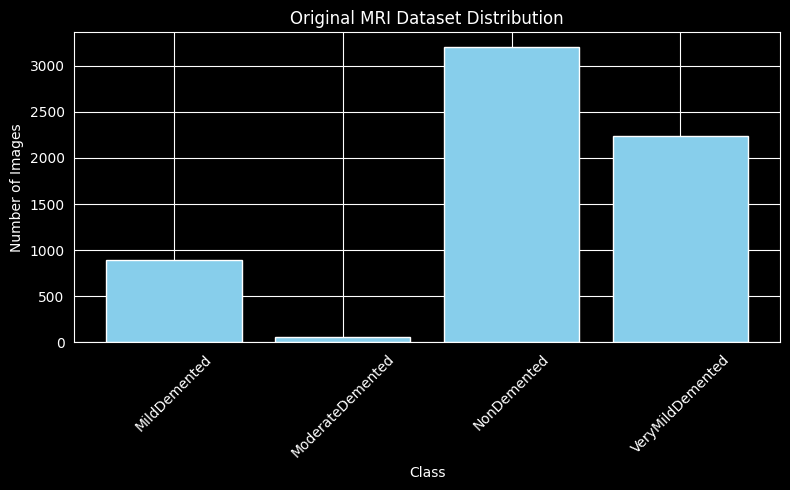

In [71]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(df_distribution["Class"], df_distribution["Image_Count"], color="skyblue")
ax.set_title("Original MRI Dataset Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Number of Images")
ax.set_xticklabels(df_distribution["Class"], rotation=45)
plt.tight_layout()
plt.show()

## 3. Split Original Dataset into Train, Validation, and Test Sets
The original dataset was split into three subsets to facilitate model training and evaluation:
- **Training Set**: 60% of the original dataset, used for model training and augmentation.
- **Validation Set**: 20% of the original dataset, used for hyperparameter tuning and model selection.
- **Test Set**: 20% of the original dataset, reserved for final model evaluation to assess generalization performance.

#### 3.1 Create DataFrame with Image Paths and Class Labels

In [6]:
records = []

for class_name in sorted(os.listdir(DATASET_DIR)):
    class_path = os.path.join(DATASET_DIR, class_name)

    if not os.path.isdir(class_path):
        continue

    for fname in os.listdir(class_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            records.append({
                "image_path": os.path.join(class_name, fname),
                "class": class_name
            })

df_original = pd.DataFrame(records)
df_original.head()

,image_path,class
0,MildDemented/mildDem302.jpg,MildDemented
1,MildDemented/mildDem293.jpg,MildDemented
2,MildDemented/mildDem348.jpg,MildDemented
3,MildDemented/mildDem295.jpg,MildDemented
4,MildDemented/mildDem713.jpg,MildDemented


#### 3.2 Split df into train, text, val sets with stratification to maintain class distribution

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(
    df_original,
    test_size=0.4,
    stratify=df_original["class"],
    random_state=42
)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3840 entries, 4943 to 596
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3840 non-null   object
 1   class       3840 non-null   object
dtypes: object(2)
memory usage: 90.0+ KB


In [8]:
df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp["class"],
    random_state=42
)
df_test.info(), df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1280 entries, 5418 to 936
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  1280 non-null   object
 1   class       1280 non-null   object
dtypes: object(2)
memory usage: 30.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1280 entries, 5373 to 5993
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  1280 non-null   object
 1   class       1280 non-null   object
dtypes: object(2)
memory usage: 30.0+ KB


(None, None)

In [9]:
df_train = df_train.copy()
df_val = df_val.copy()
df_test = df_test.copy()

df_train["split"] = "train"
df_val["split"] = "val"
df_test["split"] = "test"

df_manifest = pd.concat([df_train, df_val, df_test], ignore_index=True)
df_manifest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  6400 non-null   object
 1   class       6400 non-null   object
 2   split       6400 non-null   object
dtypes: object(3)
memory usage: 150.1+ KB


In [10]:
OUTPUT_PATH = "original_split_manifest.csv"
df_manifest.to_csv(OUTPUT_PATH, index=False)

print(f"Split manifest saved to: {OUTPUT_PATH}")

Split manifest saved to: original_split_manifest.csv


## 4. 60% Original dataset imbalance handling

/tmp/ipykernel_198562/3202845943.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_train["class"].value_counts().index, rotation=45)


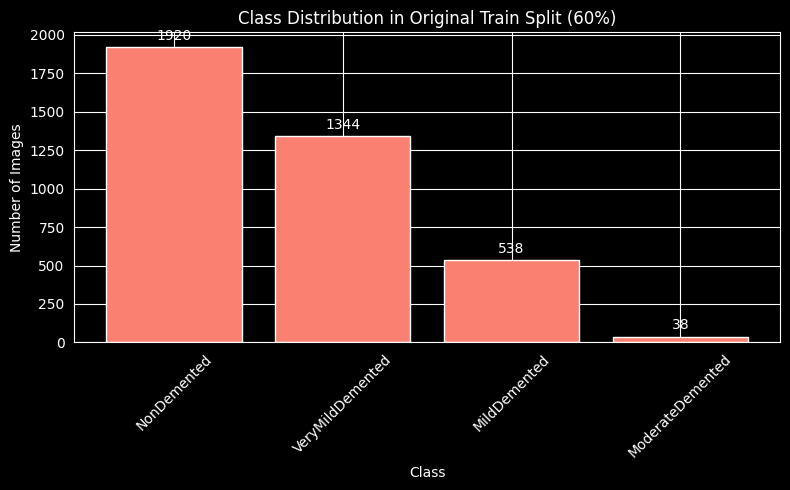

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(df_train["class"].value_counts().index, df_train["class"].value_counts().values, color="salmon")
ax.bar_label(bars, fmt="%d", padding=3)
ax.set_title("Class Distribution in Original Train Split (60%)")
ax.set_xlabel("Class")
ax.set_ylabel("Number of Images")
ax.set_xticklabels(df_train["class"].value_counts().index, rotation=45)
plt.tight_layout()
plt.show()

#### 4.1 Calculate augmentation plan based on the original training split distribution

In [19]:
target_per_class = 1000 # Avoid directly align with the max class count

class_counts = df_train["class"].value_counts()

augmentation_plan = []

for cls, count in class_counts.items():
    if count < target_per_class:
        augmentation_plan.append({
            "class": cls,
            "original_count": count,
            "target": target_per_class,
            "need_to_generate": target_per_class - count
        })

df_aug_plan = pd.DataFrame(augmentation_plan)
df_aug_plan

,class,original_count,target,need_to_generate
0,MildDemented,538,1000,462
1,ModerateDemented,38,1000,962


#### 4.2 Define the augmentation funtion

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
AUG_OUTPUT_DIR = "../dataset/original_train_balanced_aug"
os.makedirs(AUG_OUTPUT_DIR, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    brightness_range=(0.9, 1.1),
    fill_mode="nearest"
)

#### 4.3 Generate augmented images and save to disk

In [59]:
from pathlib import Path

new_records = []

for _, row in df_aug_plan.iterrows():
    cls = row["class"]
    need = row["need_to_generate"]

    df_cls = df_train[df_train["class"] == cls].reset_index(drop=True)

    cls_output_dir = os.path.join(AUG_OUTPUT_DIR, cls)
    os.makedirs(cls_output_dir, exist_ok=True)

    generated = 0
    i = 0

    while generated < need:
        img_row = df_cls.iloc[i % len(df_cls)]
        img_path = os.path.join(DATASET_DIR, img_row["image_path"])

        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        aug_iter = datagen.flow(x, batch_size=1)

        aug_img = next(aug_iter)[0]
        new_name = f"aug_{generated:05d}.png"
        save_path = os.path.join(cls_output_dir, new_name)

        save_img(save_path, aug_img)

        new_records.append({
            "image_path": os.path.join(cls, new_name), # MildDemented/aug_00001.png
            "class": cls,
            "split": "train",
            "root": AUG_OUTPUT_DIR
        })

        generated += 1
        i += 1


#### 4.4 Build new DataFrame for augmented data and save manifest

In [60]:
df_train_manifest = df_train.copy()
df_train_manifest["split"] = "train"
df_train_manifest["root"] = DATASET_DIR

df_aug_manifest = pd.DataFrame(new_records)

df_train_balanced = pd.concat(
    [df_train_manifest, df_aug_manifest],
    ignore_index=True
)
balanced_manifest_path = "original_train_balanced_aug_manifest.csv"
df_train_balanced.to_csv(balanced_manifest_path, index=False)
print(f"Balanced training manifest saved to: {balanced_manifest_path}")

Balanced training manifest saved to: original_train_balanced_aug_manifest.csv


#### 4.5 Check the new class distribution after augmentation

In [61]:
df_train_balanced["class"].value_counts()

class
NonDemented         1920
VeryMildDemented    1344
MildDemented        1000
ModerateDemented    1000
Name: count, dtype: int64

## 5. Form training dataset

In [72]:
import tensorflow as tf

IMG_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
BATCH_SIZE = 16
SEED = 42

ORIGINAL_ROOT = "../dataset/OriginalDataset"
AUGMENTED_ROOT = "../dataset/AugmentedAlzheimerDataset"
MANIFEST_PATH = "./original_split_manifest.csv"
BALANCED_MANIFEST_PATH = "./original_train_balanced_aug_manifest.csv"

#### 5.1 Read 2 manifest（original-balanced & augmented）

In [73]:
df_train_balanced = pd.read_csv(BALANCED_MANIFEST_PATH)
df_train_balanced.head()

,image_path,class,split,root
0,VeryMildDemented/verymildDem958.jpg,VeryMildDemented,train,../dataset/OriginalDataset
1,MildDemented/28 (24).jpg,MildDemented,train,../dataset/OriginalDataset
2,NonDemented/nonDem2468.jpg,NonDemented,train,../dataset/OriginalDataset
3,NonDemented/nonDem236.jpg,NonDemented,train,../dataset/OriginalDataset
4,MildDemented/mildDem78.jpg,MildDemented,train,../dataset/OriginalDataset


In [74]:
aug_records = []

for cls in sorted(os.listdir(AUGMENTED_ROOT)):
    cls_path = os.path.join(AUGMENTED_ROOT, cls)
    if not os.path.isdir(cls_path):
        continue

    for fname in os.listdir(cls_path):
        if fname.lower().endswith((".jpg", ".png", ".jpeg")):
            aug_records.append({
                "image_path": os.path.join(cls, fname),
                "class": cls
            })

df_aug = pd.DataFrame(aug_records)
df_aug.head()

,image_path,class
0,MildDemented/05784408-ab8e-4329-802b-4114d8b12...,MildDemented
1,MildDemented/3513f7c7-4483-4a6c-a2e9-a5cff1b40...,MildDemented
2,MildDemented/c57958cf-bd07-4307-accb-3ed124c58...,MildDemented
3,MildDemented/617613e0-55d7-401e-bdf0-f4b72d973...,MildDemented
4,MildDemented/9ee7a15a-7684-43a0-abc8-031b53498...,MildDemented


#### 5.2 Class to index mapping

In [75]:
class_names = sorted(df_train_balanced["class"].unique())
class_to_id = {name: idx for idx, name in enumerate(class_names)}
id_to_class = {v: k for k, v in class_to_id.items()}

NUM_CLASSES = len(class_names)
class_to_id

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

#### 5.3 Define immage loading and preprocessing function

In [80]:
from tensorflow.keras.applications.xception import preprocess_input
def load_image(image_path, label, root_dir):
    full_path = tf.strings.join([root_dir, "/", image_path])
    image = tf.io.read_file(full_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label

#### 5.4 Build Original-balanced train dataset

In [81]:
paths_orig = df_train_balanced["image_path"].values
labels_orig = df_train_balanced["class"].map(class_to_id).values.astype(np.int32)
roots = df_train_balanced["root"].values

ds_orig = tf.data.Dataset.from_tensor_slices((paths_orig, labels_orig, roots))

ds_orig = ds_orig.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

ds_orig = ds_orig.shuffle(2048, seed=SEED).repeat()

#### 5.5 Build Augmented train dataset

In [82]:
paths_aug = df_aug["image_path"].values
labels_aug = df_aug["class"].map(class_to_id).values.astype(np.int32)

ds_aug = tf.data.Dataset.from_tensor_slices((paths_aug, labels_aug))

ds_aug = ds_aug.map(
    lambda x, y: load_image(x, y, AUGMENTED_ROOT),
    num_parallel_calls=tf.data.AUTOTUNE
)

ds_aug = ds_aug.shuffle(4096, seed=SEED).repeat()

#### 5.6 Mix original-balanced and augmented datasets with a 70:30 ratio

In [83]:
MIX_RATIO = [0.7, 0.3]

train_ds = tf.data.Dataset.sample_from_datasets(
    [ds_orig, ds_aug],
    weights=MIX_RATIO,
    seed=SEED
)

train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#### 5.7 Calculate steps per epoch based on the effective sample size after augmentation

In [84]:
steps_per_epoch = len(df_train_balanced["image_path"]) // BATCH_SIZE
print("Steps per epoch:", steps_per_epoch)

Steps per epoch: 329


#### 5.8 Calculate class weights for the original balanced training set (before augmentation) to handle any remaining imbalance

In [85]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_orig),
    y=labels_orig
)

class_weight_dict = dict(enumerate(class_weights))
class_weight_dict


{0: np.float64(1.316),
 1: np.float64(1.316),
 2: np.float64(0.6854166666666667),
 3: np.float64(0.9791666666666666)}

## 6. Form Validation and Test Datasets

In [86]:
df_val = pd.read_csv(MANIFEST_PATH)
df_val = df_val[df_val["split"] == "val"]

paths_val = df_val["image_path"].values
labels_val = df_val["class"].map(class_to_id).values

val_ds = tf.data.Dataset.from_tensor_slices((paths_val, labels_val))

val_ds = val_ds.map(
    lambda x, y: load_image(x, y, DATASET_DIR),
    num_parallel_calls=tf.data.AUTOTUNE
)

val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [87]:
df_test = pd.read_csv(MANIFEST_PATH)
df_test = df_test[df_test["split"] == "test"]

paths_test = df_test["image_path"].values
labels_test = df_test["class"].map(class_to_id).values

test_ds = tf.data.Dataset.from_tensor_slices((paths_test, labels_test))

test_ds = test_ds.map(
    lambda x, y: load_image(x, y, DATASET_DIR),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 7. Build Model and Compile with Class Weights

In [88]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax

NUM_CLASSES = len(class_names)  # 4

base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling="max"
)

base_model.trainable = True
# Freeze the first 100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False

model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.35),
    layers.Dense(128, activation="relu",
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # L2 regularization,
    layers.Dropout(0.25),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=Adamax(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 9,741,132 (37.16 MB)

 Non-trainable params: 11,383,136 (43.42 MB)

## 8.Plot model graph

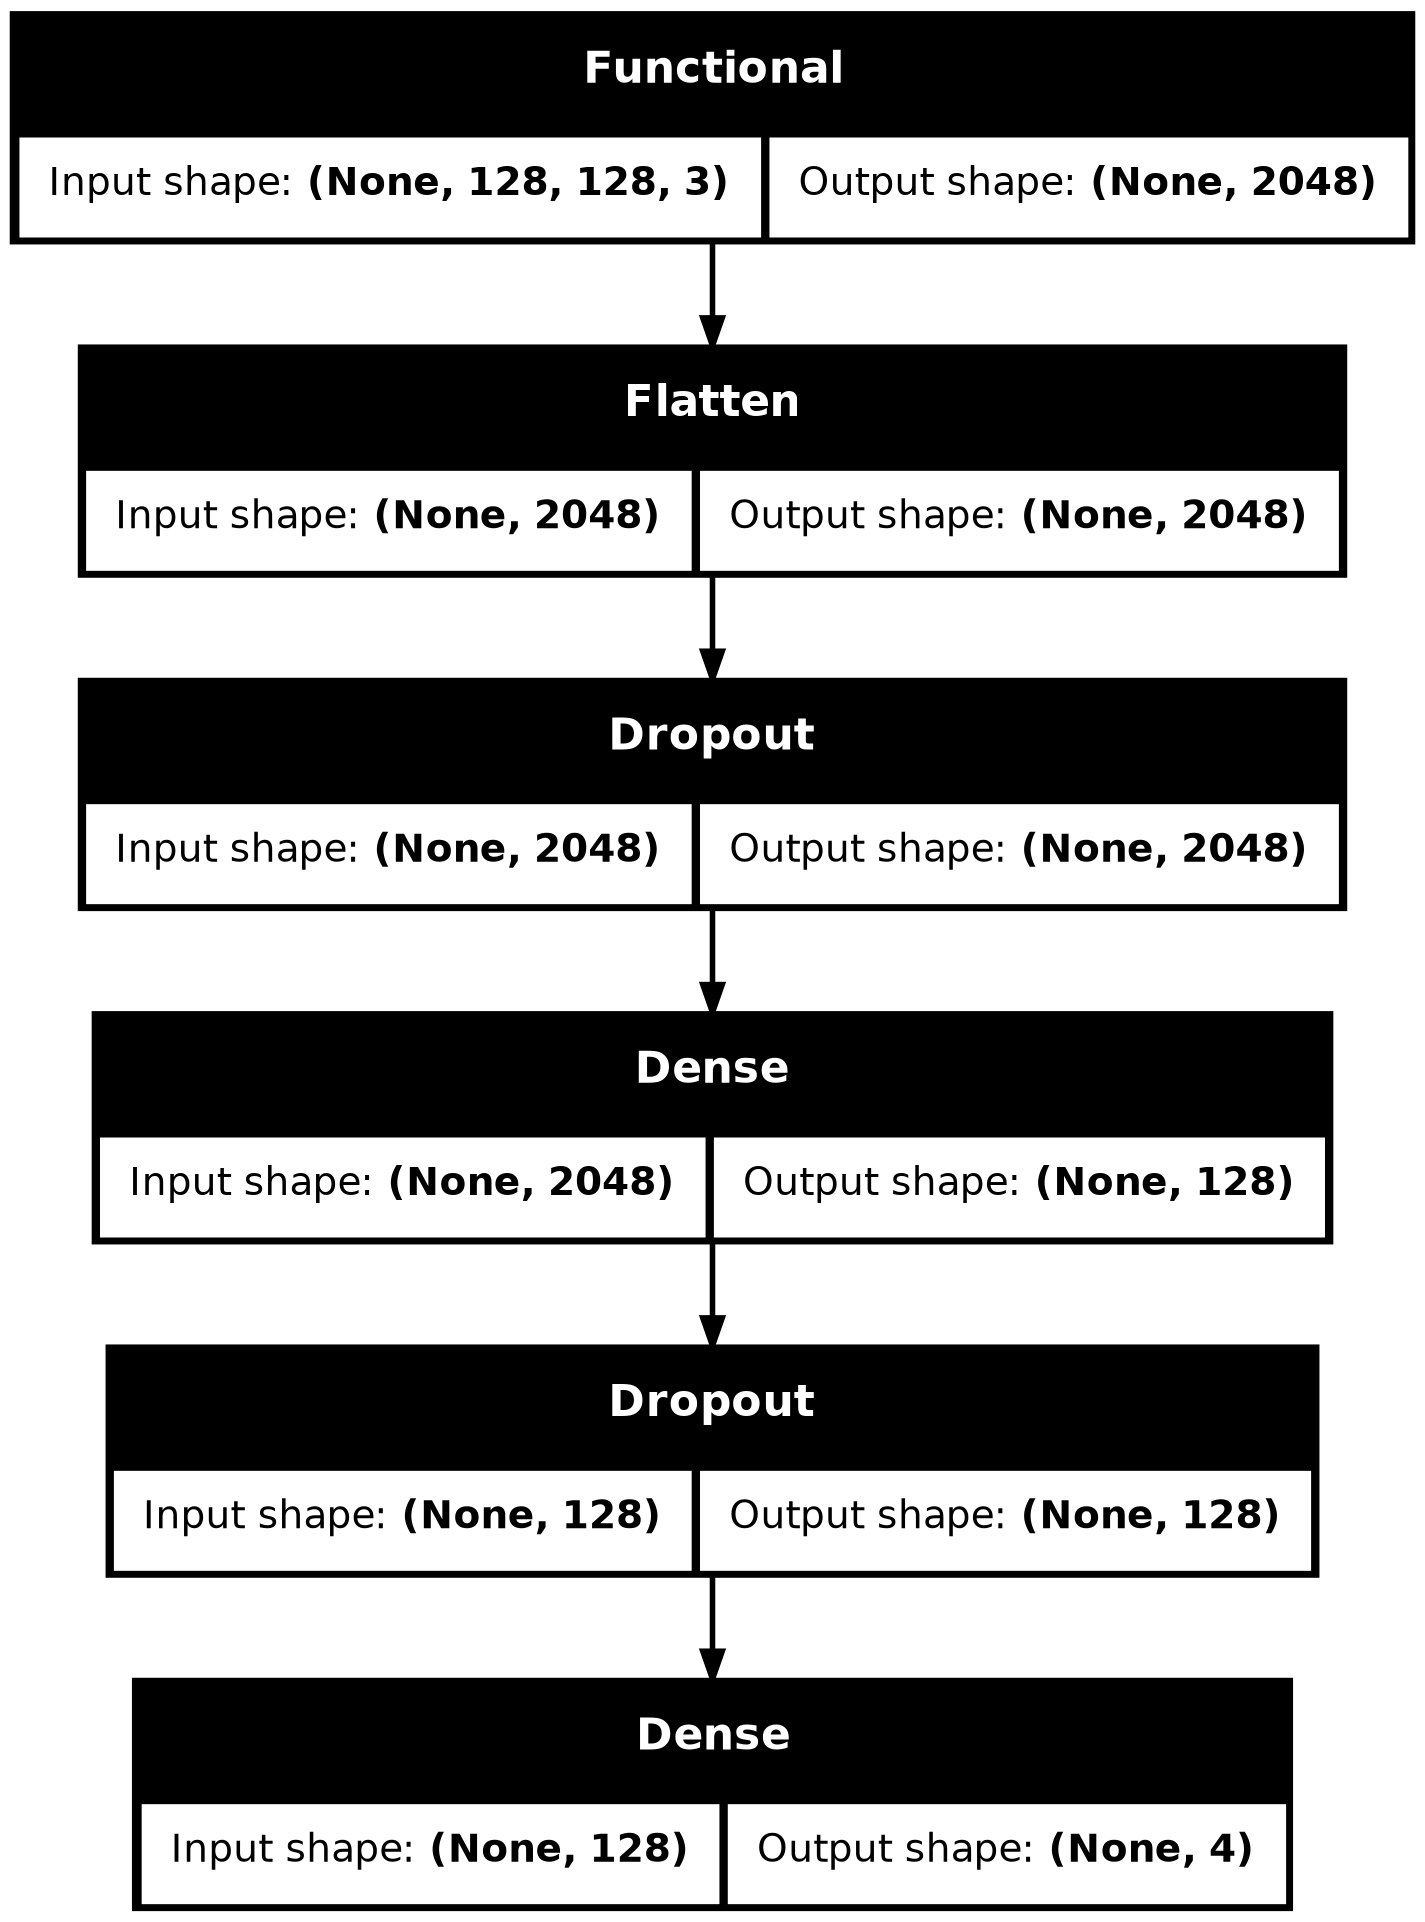

In [89]:
model.build(input_shape=(None, *INPUT_SHAPE))
tf.keras.utils.plot_model(model, show_shapes=True)

## 9. Early Stop & Learning rate reduction callbacks

In [90]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [91]:
# Custom callback to print detailed metrics and overfitting gap at the end of each epoch
class DetailedMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy', 0)
        val_acc = logs.get('val_accuracy', 0)
        train_loss = logs.get('loss', 0)
        val_loss = logs.get('val_loss', 0)
        gap = abs(train_acc - val_acc)

        print(f"\n{'='*70}")
        print(f"Epoch {epoch+1} Metrics:")
        print(f"{'='*70}")
        print(f"  Training   → Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"  Validation → Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        print(f"  Overfitting Gap: {gap:.4f}")

        # 预警
        if val_loss > 2.5:
            print(f"  ⚠️  WARNING: High validation loss ({val_loss:.2f}) - possible instability")
        if gap > 0.25:
            print(f"  ⚠️  WARNING: Large train/val gap ({gap:.2f}) - overfitting detected")
        if val_loss < 1.0 and val_acc > 0.70:
            print(f"  ✅ GOOD: Model performing well!")

metrics_callback = DetailedMetricsCallback()

## 10. Model Saving & Resume Training Logic

#### 10.1 Define paths and training control flags

In [92]:
import os
import json
import tensorflow as tf

MODEL_PATH = "models/alzheimer_xception_model.keras"
EPOCH_TRACKER_PATH = "models/epoch_tracker.json"

os.makedirs("models", exist_ok=True)

TOTAL_EPOCHS = 40
CONTINUE_TRAINING = True

#### 10.2 Load epoch tracker (for resume training)

In [93]:
if os.path.exists(EPOCH_TRACKER_PATH):
    with open(EPOCH_TRACKER_PATH, "r") as f:
        epoch_data = json.load(f)
        last_epoch = int(epoch_data.get("last_epoch", 0))
else:
    last_epoch = 0

print("Last completed epoch:", last_epoch)

Last completed epoch: 0


#### 10.3 Load existing model if available <br>
If a saved .keras model exists, we load and recompile it. Otherwise, we continue with the newly built model.

In [94]:
if os.path.exists(MODEL_PATH):
    print(f"Loading existing model from {MODEL_PATH}...")
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)

    base_model_loaded = model.layers[0]  # Xception base model is the first layer in our Sequential model
    base_model_loaded.trainable = True
    for layer in base_model_loaded.layers[:100]:  # Freeze the first 100 layers
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    print("Model loaded and recompiled.")
else:
    print("No saved model found. Training a new model.")

No saved model found. Training a new model.


#### 10.4 Define AutoSave callback (epoch-level saving)

In [95]:
from tensorflow.keras.callbacks import Callback

class AutoSaveCallback(Callback):
    def __init__(self, model_path, tracker_path):
        super().__init__()
        self.model_path = model_path
        self.tracker_path = tracker_path

    def on_epoch_end(self, epoch, logs=None):
        self.model.save(self.model_path)
        with open(self.tracker_path, "w") as f:
            json.dump({"last_epoch": epoch + 1}, f)

        print(f"\n[AutoSave] Model saved to {self.model_path}")
        print(f"[AutoSave] Last epoch recorded: {epoch + 1}")

In [96]:
auto_save_cb = AutoSaveCallback(MODEL_PATH, EPOCH_TRACKER_PATH)

## 11.Train the Model (IMPORTANT: class_weight)

In [97]:
history = None

if CONTINUE_TRAINING:
    if last_epoch >= TOTAL_EPOCHS:
        print(f"Training already completed ({last_epoch}/{TOTAL_EPOCHS} epochs).")
    else:
        print(f"Training from epoch {last_epoch} to {TOTAL_EPOCHS}...")

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=TOTAL_EPOCHS,
            steps_per_epoch=steps_per_epoch,
            initial_epoch=last_epoch,
            callbacks=[
                auto_save_cb,
                early_stop,
                reduce_lr,
                metrics_callback
            ],
            class_weight=class_weight_dict  # ✅ IMPORTANT
        )
else:
    print("CONTINUE_TRAINING=False, skipping training.")

Training from epoch 0 to 40...
Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5315 - loss: 1.2314
[AutoSave] Model saved to models/alzheimer_xception_model.keras
[AutoSave] Last epoch recorded: 1

Epoch 1 Metrics:
  Training   → Loss: 1.1651, Accuracy: 0.6033
  Validation → Loss: 1.4899, Accuracy: 0.4742
  Overfitting Gap: 0.1291
329/329 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.6033 - loss: 1.1651 - val_accuracy: 0.4742 - val_loss: 1.4899 - learning_rate: 1.0000e-04
Epoch 2/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7570 - loss: 0.8707
[AutoSave] Model saved to models/alzheimer_xception_model.keras
[AutoSave] Last epoch recorded: 2

Epoch 2 Metrics:
  Training   → Loss: 0.8292, Accuracy: 0.7454
  Validation → Loss: 0.9942, Accuracy: 0.6578
  Overfitting Gap: 0.0876
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.7454 - loss: 0.8292 - val_accuracy: 0.6578 - val_loss: 0.9942 - learning_rate: 1.0000e-04
Epoch 3/40
328/329 ━━━━━━━━━━━━━━

## 12. Evaluate on Test Set (Original Only)

In [98]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9539 - loss: 0.3094
Test Loss: 0.30941253900527954
Test Accuracy: 0.953906238079071


## 13. Predictions, Classification Report, Confusion Matrix

#### 13.1 Generate predictions

In [99]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

#### 13.2 Classification report <br>
For imbalanced datasets, macro-averaged precision, recall, and F1-score are more informative than accuracy alone.

In [100]:
from sklearn.metrics import classification_report, confusion_matrix
index_to_class = {v: k for k, v in class_to_id.items()}
target_names = [index_to_class[i] for i in range(len(class_names))]

print("Classification Report:")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=target_names,
        digits=4
    )
)

Classification Report:
                  precision    recall  f1-score   support

    MildDemented     0.9942    0.9609    0.9773       179
ModerateDemented     1.0000    1.0000    1.0000        13
     NonDemented     0.9294    0.9875    0.9576       640
VeryMildDemented     0.9758    0.9018    0.9374       448

        accuracy                         0.9539      1280
       macro avg     0.9749    0.9625    0.9681      1280
    weighted avg     0.9554    0.9539    0.9537      1280



#### 13.3 Confusion matrix visualization

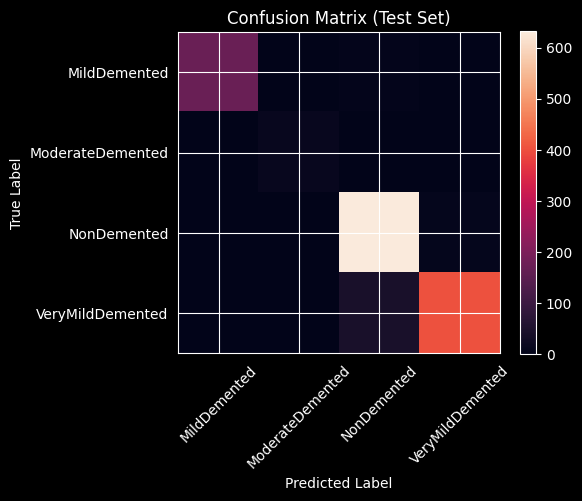

In [101]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test Set)")
plt.colorbar()

ticks = np.arange(len(class_names))
plt.xticks(ticks, target_names, rotation=45)
plt.yticks(ticks, target_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 14 Plot Training Curves (if training occurred)

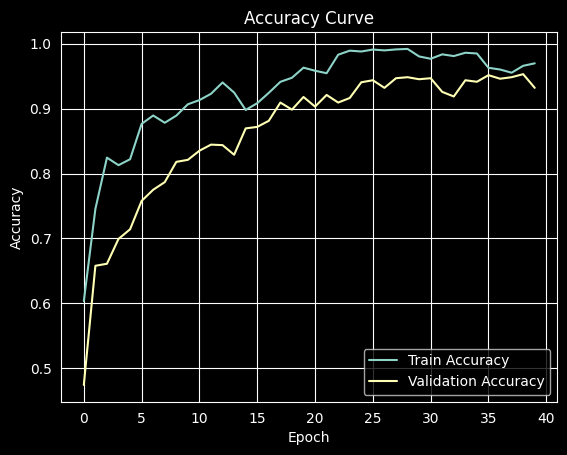

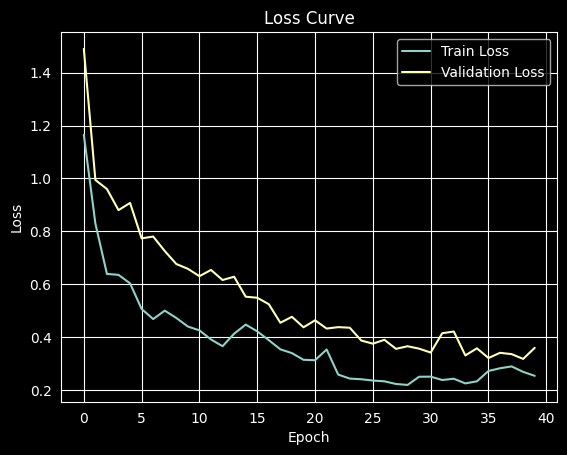

In [102]:
if history is not None:
    plt.figure()
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## 15. Final Save

In [103]:
model.save(MODEL_PATH)
print(f"Final model saved to {MODEL_PATH}")

Final model saved to models/alzheimer_xception_model.keras
